In [39]:
import logging
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import joblib
import time
import sys

In [40]:
# Add the src directory to the Python path
sys.path.append(str(Path().resolve().parent / 'src'))

from create_folds import create_folds
from data_cleaning import drop_columns, impute_missing_values
from data_preprocessing import preprocess_data
from log_reg_model import train_model, evaluate_model, load_data

In [41]:
# Step 2: Data Cleaning
data = load_data(Path("../input/train_folds.csv"))
df = drop_columns(data)

all_accuracies = []

for fold in range(5):
    logging.info(f"Processing fold {fold}...")
    
    # Step 3: Data Imputation
    fold_df = impute_missing_values(df, fold)
    
    # Step 4: Data Preprocessing
    fold_df = preprocess_data(fold_df, fold)
    
    # Step 5: Model Training
    X = fold_df.drop(["Converted", "kfold"], axis=1)
    y = fold_df["Converted"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = train_model(X_train, y_train)
    
    # Step 6: Model Evaluation
    accuracy, report, matrix = evaluate_model(model, X_test, y_test)
    all_accuracies.append(accuracy)
    
    # Print results
    print(f"Fold {fold} Results:")
    print(f"Accuracy: {accuracy}")
    # print(f"Classification Report:\n{report}")
    # print(f"Confusion Matrix:\n{matrix}")

c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 0 Results:
Accuracy: 0.797077922077922
Fold 1 Results:
Accuracy: 0.8057359307359307
Fold 2 Results:
Accuracy: 0.7997835497835498


c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 3 Results:
Accuracy: 0.7954545454545454


c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 4 Results:
Accuracy: 0.795995670995671


In [42]:
fold = 0
logging.info(f"Processing fold {fold}...")

# Step 3: Data Imputation
fold_df = impute_missing_values(df, fold)

# Step 4: Data Preprocessing
fold_df = preprocess_data(fold_df, fold)

# Step 5: Model Training
X = fold_df.drop(["Converted", "kfold"], axis=1)
y = fold_df["Converted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = train_model(X_train, y_train)

# Step 6: Model Evaluation
accuracy, report, matrix = evaluate_model(model, X_test, y_test)

# Print results
print(f"Fold {fold} Results:")
print(f"Accuracy: {accuracy}")
# print(f"Classification Report:\n{report}")
# print(f"Confusion Matrix:\n{matrix}")



Fold 0 Results:
Accuracy: 0.797077922077922


c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Coefficients

In [43]:
# Calculate feature importance

coefficients = model.coef_[0]
# odds_ratios = [round(float(x), 2) for x in list(map(lambda x: 2**x, coefficients))]
odds_ratios = np.exp(coefficients)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})

# Sort by absolute value of coefficient
feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)
print(feature_importance)

                                     Feature  Coefficient  Odds Ratio
13                 Lead Origin_Lead Add Form     2.772180   15.993462
27              Lead Source_Welingak Website     2.020784    7.544241
60         Last Notable Activity_Unreachable     1.372994    3.947150
0                               Do Not Email    -1.225931    0.293484
41     Last Activity_Olark Chat Conversation    -1.182939    0.306377
..                                       ...          ...         ...
11    A free copy of Mastering The Interview     0.079330    1.082561
48  Last Activity_Visited Booth in Tradeshow    -0.064662    0.937384
61        Last Notable Activity_Unsubscribed     0.010255    1.010308
28                          Lead Source_bing     0.000357    1.000357
15                Lead Origin_Quick Add Form     0.000000    1.000000

[62 rows x 3 columns]


## Model Probabilities

In [44]:
# Get probability of conversion
probs = model.predict_proba(X_test)[:, 1] # Probability of the positive class

In [45]:
# Apply a custom threshold to get the predicted class
threshold = 0.45
y_pred = (probs >= threshold).astype(int)

# Evaluate the model with the custom threshold
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with threshold {threshold}: {accuracy}")

Accuracy with threshold 0.45: 0.7981601731601732


## Plotting the ROC Curve and Calculating AUC

In [46]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calculate AUC
auc_score = roc_auc_score(y_test, probs)
print(f"AUC: {auc_score}")

AUC: 0.8615547527096051


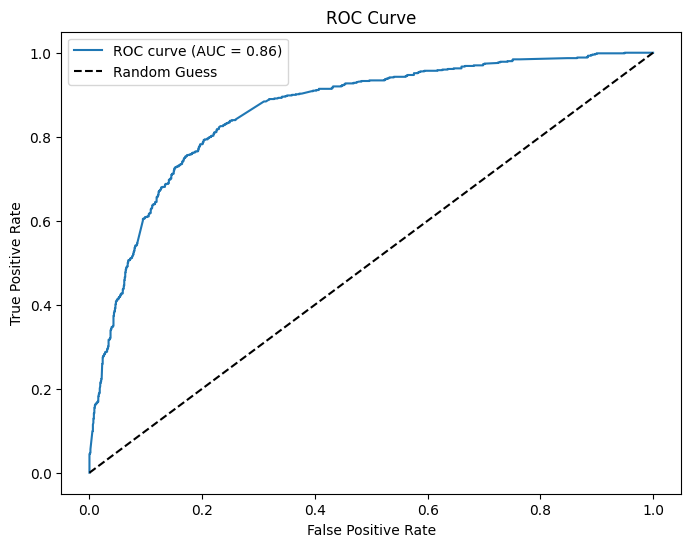

In [47]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Finding Optimal Cut-off Point

Optimal cut-off point is the point where we get the best accuracy. We can find it by calculating the point where the sum of sensitivity and specificity is maximum.

Best F1-Score threshold: 0.32, Best F1-Score: 0.7469095640858816
Best Accuracy threshold: 0.47000000000000003, Best Accuracy: 0.801948051948052
Best Precision threshold: 0.99, Best Precision: 1.0
Best Recall threshold: 0.0, Best Recall: 1.0
Best threshold: 0.5


<Figure size 800x600 with 0 Axes>

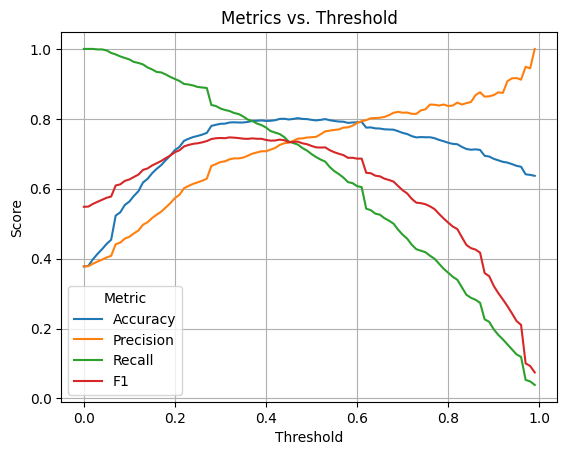

In [57]:
# Let's create columns with different probability thresholds
thresholds = np.linspace(0, 0.99, 100)
metrics = []
best_threshold = 0.5
best_f1, best_accuracy, best_precision, best_recall = 0, 0, 0, 0
best_f1_threshold, best_accuracy_threshold, best_precision_threshold, best_recall_threshold = 0, 0, 0, 0

for threshold in thresholds:
    y_pred = (probs >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics.append([threshold, accuracy, precision, recall, f1])
    if f1 > best_f1:
        best_f1 = f1
        best_f1_threshold = threshold
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_threshold = threshold
    if precision > best_precision:
        best_precision = precision
        best_precision_threshold = threshold
    if recall > best_recall:
        best_recall = recall
        best_recall_threshold = threshold
    if recall == precision:
        best_threshold = threshold

metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Accuracy", "Precision", "Recall", "F1"])
metrics_df = metrics_df.set_index("Threshold")

print(f"Best F1-Score threshold: {best_f1_threshold}, Best F1-Score: {best_f1}")
print(f"Best Accuracy threshold: {best_accuracy_threshold}, Best Accuracy: {best_accuracy}")
print(f"Best Precision threshold: {best_precision_threshold}, Best Precision: {best_precision}")
print(f"Best Recall threshold: {best_recall_threshold}, Best Recall: {best_recall}")
print(f"Best threshold: {best_threshold}")

# Plot the metrics
plt.figure(figsize=(8, 6))
metrics_df.plot()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics vs. Threshold")
plt.legend(title="Metric")
plt.grid(True)
plt.show()

## Precision-Recall Curve

In [49]:
# Precision-Recall Curve
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 1.0
Recall: 0.03868194842406877
F1 Score: 0.07448275862068965


Average Precision Score: 0.78


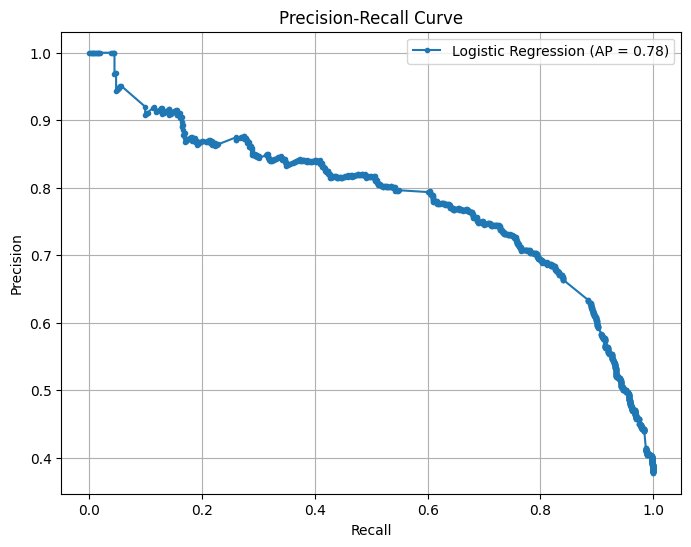

In [50]:
# Step 2: Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Step 3: Calculate the average precision score
average_precision = average_precision_score(y_test, probs)
print(f'Average Precision Score: {average_precision:.2f}')

# Step 4: Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Logistic Regression (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Best F1-Score threshold: 0.31810810810810813, Best F1-Score: 0.7475665152498377
Best Accuracy threshold: 0.47270270270270276, Best Accuracy: 0.8024891774891775
Best Precision threshold: 0.9850450450450451, Best Precision: 1.0
Best Recall threshold: 0.0, Best Recall: 1.0
Best threshold (Recall ≈ Precision): 0.4608108108108108


<Figure size 1500x1000 with 0 Axes>

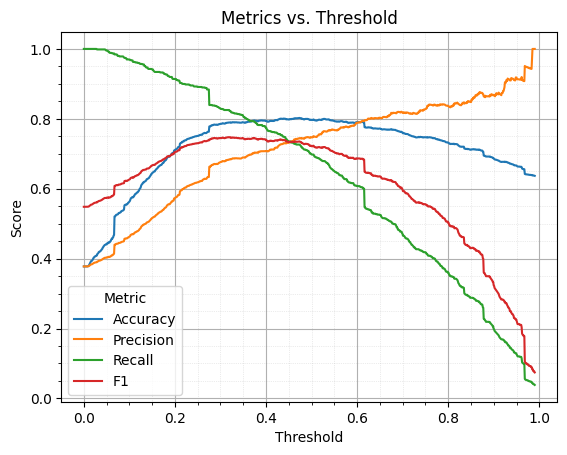

In [70]:
def evaluate_thresholds(probs, y_test, thresholds=np.linspace(0, 0.99, 1000), tol=0.01):
    metrics = []
    best_f1, best_accuracy, best_precision, best_recall = 0, 0, 0, 0
    best_f1_threshold, best_accuracy_threshold, best_precision_threshold, best_recall_threshold = 0, 0, 0, 0
    best_threshold = 0.1

    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        metrics.append([threshold, accuracy, precision, recall, f1])
        
        if f1 > best_f1:
            best_f1 = f1
            best_f1_threshold = threshold
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_accuracy_threshold = threshold
        if precision > best_precision:
            best_precision = precision
            best_precision_threshold = threshold
        if recall > best_recall:
            best_recall = recall
            best_recall_threshold = threshold
        if abs(recall - precision) <= tol:  # Compare within the tolerance
            best_threshold = threshold

    metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Accuracy", "Precision", "Recall", "F1"])
    metrics_df = metrics_df.set_index("Threshold")

    print(f"Best F1-Score threshold: {best_f1_threshold}, Best F1-Score: {best_f1}")
    print(f"Best Accuracy threshold: {best_accuracy_threshold}, Best Accuracy: {best_accuracy}")
    print(f"Best Precision threshold: {best_precision_threshold}, Best Precision: {best_precision}")
    print(f"Best Recall threshold: {best_recall_threshold}, Best Recall: {best_recall}")
    print(f"Best threshold (Recall ≈ Precision): {best_threshold}")

    return metrics_df, best_f1_threshold, best_accuracy_threshold, best_precision_threshold, best_recall_threshold, best_threshold


def plot_metrics(metrics_df):
    plt.figure(figsize=(15, 10))
    metrics_df.plot()
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Metrics vs. Threshold")
    plt.legend(title="Metric")
    plt.grid(True, which='both')
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.3)

    plt.show()

# Example usage:
probs = model.predict_proba(X_test)[:, 1]
metrics_df, best_f1_threshold, best_accuracy_threshold, best_precision_threshold, best_recall_threshold, best_threshold = evaluate_thresholds(probs, y_test)
plot_metrics(metrics_df)


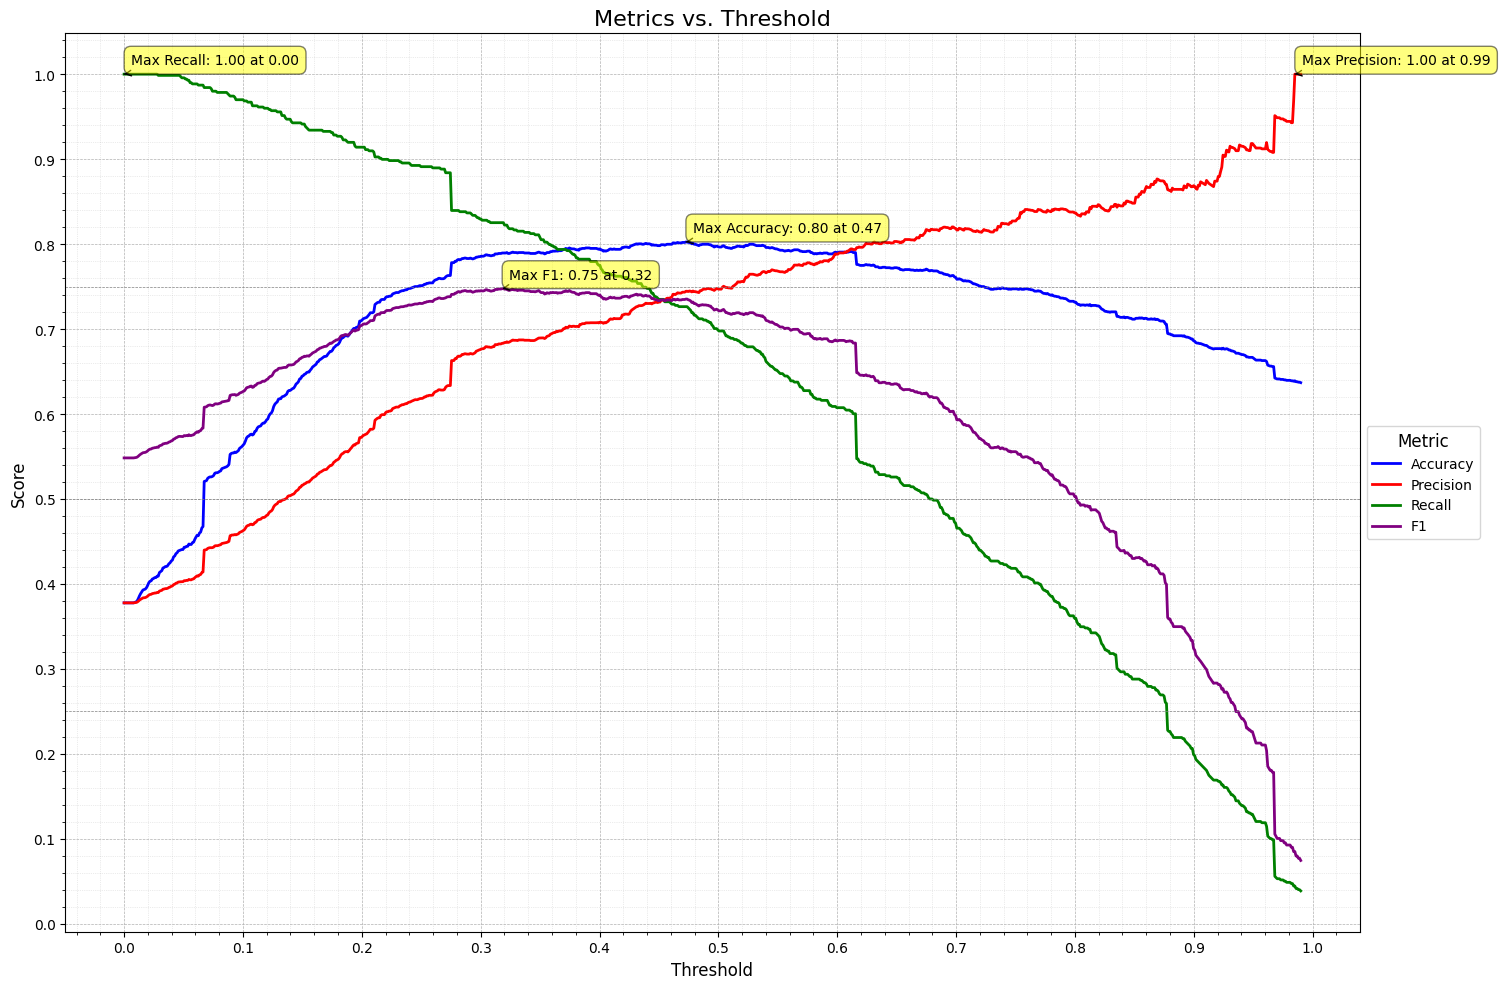

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics_df, figsize=(15, 10), title="Metrics vs. Threshold", 
                 custom_colors=None, save_path=None):
    """
    Plot metrics against thresholds with improved formatting and options.
    
    Parameters:
    - metrics_df: DataFrame with metrics (columns) and thresholds (index)
    - figsize: Tuple for figure size
    - title: String for plot title
    - custom_colors: Dict mapping metric names to colors (optional)
    - save_path: String path to save the figure (optional)
    """
    plt.figure(figsize=figsize)
    
    # Use custom colors if provided, otherwise use default color cycle
    if custom_colors:
        for column, color in custom_colors.items():
            plt.plot(metrics_df.index, metrics_df[column], label=column, color=color, linewidth=2)
    else:
        for column in metrics_df.columns:
            plt.plot(metrics_df.index, metrics_df[column], label=column, linewidth=2)
    
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend(title="Metric", title_fontsize=12, fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Set x-axis ticks
    plt.xticks(np.arange(0, 1.1, 0.1))
    
    # Set y-axis ticks
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    # Add grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.3)
    
    # Add horizontal lines at 0.25, 0.5, and 0.75 for easier reading
    for y in [0.25, 0.5, 0.75]:
        plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
    
    # Improve layout
    plt.tight_layout()
    
    # Add text annotations for max values
    for column in metrics_df.columns:
        max_value = metrics_df[column].max()
        max_threshold = metrics_df[column].idxmax()
        plt.annotate(f'Max {column}: {max_value:.2f} at {max_threshold:.2f}',
                     xy=(max_threshold, max_value), xytext=(5, 5),
                     textcoords='offset points', ha='left', va='bottom',
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Example usage:
custom_colors = {'Accuracy': 'blue', 'Precision': 'red', 'Recall': 'green', 'F1': 'purple'}
plot_metrics(metrics_df, custom_colors=custom_colors)
# plot_metrics(metrics_df, custom_colors=custom_colors, save_path='metrics_plot.png')

## Metrics based on the best threshold

In [73]:
# Set the chosen threshold
chosen_threshold = 0.46

# Apply the threshold to get predictions
y_pred = (probs >= chosen_threshold).astype(int)

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, probs)

# Print the results
print(f"Metrics at Threshold {chosen_threshold}:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc_score}")

Metrics at Threshold 0.46:
Accuracy: 0.7997835497835498
Precision: 0.7369942196531792
Recall: 0.7306590257879656
F1-Score: 0.7338129496402878
AUC: 0.8615547527096051


## Metrics of all folds

In [74]:
for fold in range(5):
    logging.info(f"Processing fold {fold}...")
    
    # Step 3: Data Imputation
    fold_df = impute_missing_values(df, fold)
    
    # Step 4: Data Preprocessing
    fold_df = preprocess_data(fold_df, fold)
    
    # Step 5: Model Training
    X = fold_df.drop(["Converted", "kfold"], axis=1)
    y = fold_df["Converted"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = train_model(X_train, y_train)
    
    # Step 6: Model Evaluation
    accuracy, report, matrix = evaluate_model(model, X_test, y_test)
    all_accuracies.append(accuracy)
    
    # Predict probabilities
    probs = model.predict_proba(X_test)[:, 1]

    # Evaluate the model with the custom threshold
    threshold = 0.46
    y_pred = (probs >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, probs)

    # Print results
    print(f"Fold {fold} Results:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc_score}")
    print()  

c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 0 Results:
Accuracy: 0.7997835497835498
Precision: 0.7369942196531792
Recall: 0.7306590257879656
F1 Score: 0.7338129496402878
AUC: 0.8615547527096051

Fold 1 Results:
Accuracy: 0.8068181818181818
Precision: 0.7590551181102362
Recall: 0.7026239067055393
F1 Score: 0.7297501892505678
AUC: 0.8615141532393632



c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 2 Results:
Accuracy: 0.801948051948052
Precision: 0.7624633431085044
Recall: 0.7182320441988951
F1 Score: 0.7396870554765291
AUC: 0.8754061314169993



c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 3 Results:
Accuracy: 0.8003246753246753
Precision: 0.7553956834532374
Recall: 0.7251381215469613
F1 Score: 0.7399577167019028
AUC: 0.8674659857258016

Fold 4 Results:
Accuracy: 0.8008658008658008
Precision: 0.7795389048991355
Recall: 0.7156084656084656
F1 Score: 0.7462068965517241
AUC: 0.8785685214256642



c:\Users\Suraj\AppData\Local\pypoetry\Cache\virtualenvs\lead_scoring-r0dzUjaH-py3.12\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
